In [ ]:
a = spaces.Box(shape=(3,3), low=1,high=10)

In [ ]:
a.sample()

array([[4.3099885, 7.0077977, 9.102952 ],
       [5.8691287, 3.8419774, 8.43908  ],
       [6.2610497, 7.5150576, 1.607401 ]], dtype=float32)

In [ ]:
FEATURES = ['presence', 'orientation', 'v']
GRID_SIZE= np.array([[-1.5*5, 1.5*5], [-1.5*5, 1.5*5]])
GRID_STEP = np.array([5, 5])

grid_shape = np.asarray(np.floor((GRID_SIZE[:, 1] - GRID_SIZE[:, 0]) / GRID_STEP),
                                dtype=np.uint8)

In [8]:
grid_shape

array([3, 3], dtype=uint8)

In [1]:
import numpy as np
import random
import sys
# from Env_Builder import World

from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import time
    
# def isConnected(world0):
#     sys.setrecursionlimit(10000)
#     world0 = world0.copy()

#     def firstFree(world0):
#         for x in range(world0.shape[0]):
#             for y in range(world0.shape[1]):
#                 if world0[x, y] == 0:
#                     return x, y

#     def floodfill(world, i, j):
#         sx, sy = world.shape[0], world.shape[1]
#         if i < 0 or i >= sx or j < 0 or j >= sy:  # out of bounds, return
#             return
#         if world[i, j] == -1: return
#         world[i, j] = -1
#         floodfill(world, i + 1, j)
#         floodfill(world, i, j + 1)
#         floodfill(world, i - 1, j)
#         floodfill(world, i, j - 1)

#     i, j = firstFree(world0)
#     floodfill(world0, i, j)
#     if np.any(world0 == 0):
#         return False
#     else:
#         return True


# def GetConnectedRegion(world, regions_dict, x, y):
#     sys.setrecursionlimit(1000000)
#     '''returns a list of tuples of connected squares to the given tile
#     this is memorized with a dict'''
#     if (x, y) in regions_dict:
#         return regions_dict[(x, y)]
#     visited = set()
#     sx, sy = world.shape[0], world.shape[1]
#     work_list = [(x, y)]
#     while len(work_list) > 0:
#         (i, j) = work_list.pop()
#         if i < 0 or i >= sx or j < 0 or j >= sy:  # out of bounds, return
#             continue
#         if world[i, j] == -1:
#             continue  # crashes
#         if world[i, j] > 0:
#             regions_dict[(i, j)] = visited
#         if (i, j) in visited: continue
#         visited.add((i, j))
#         work_list.append((i + 1, j))
#         work_list.append((i, j + 1))
#         work_list.append((i - 1, j))
#         work_list.append((i, j - 1))
#     regions_dict[(x, y)] = visited
#     return visited

# plt.ion()
# fig, ax = plt.subplots()

def maze_generator(env_size=(10, 70), wall_components=(1, 8), obstacle_density=None,
                   go_straight=0.8):
    min_size, max_size = env_size
    min_component, max_component = wall_components
    num_components = np.random.randint(
        low=min_component, high=max_component + 1)
    assert min_size > 5
    # todo: write comments
    """
    num_agents,
    IsDiagonal,
    min_size: min length of the 'radius' of the map,
    max_size: max length of the 'radius' of the map,
    complexity,
    obstacle_density,
    go_straight,
    """
    if obstacle_density is None:
        obstacle_density = [0, 1]

    def maze(h, w, total_density=0):
        # Only odd shapes
        assert h > 0 and w > 0, "You are giving non-positive width and height"
        shape = ((h // 2) * 2 + 3, (w // 2) * 2 + 3)
        # Adjust num_components and density relative to maze world_size
        # density    = int(density * ((shape[0] // 2) * (shape[1] // 2))) // 20 # world_size of components
        density = int(shape[0] * shape[1] * total_density //
                      num_components) if num_components != 0 else 0
        print(f"density:{density}, components:{num_components}")
        # Build actual maze
        Z = np.zeros(shape, dtype='int')
        # Fill borders
        Z[0, :] = Z[-1, :] = 1
        Z[:, 0] = Z[:, -1] = 1
        # Make aisles
        for i in range(density):
            # print(f"i_idx:{i}")
            x, y = np.random.randint(0, shape[1] // 2) * 2, np.random.randint(0, shape[
                0] // 2) * 2  # pick a random position
            Z[y, x] = 1
            last_dir = 0
            for j in range(num_components):
                neighbours = []
                # print(f"    j_idx:{j}")
                if x > 1:
                    neighbours.append((y, x - 2))
                if x < shape[1] - 2:
                    neighbours.append((y, x + 2))
                if y > 1:
                    neighbours.append((y - 2, x))
                if y < shape[0] - 2:
                    neighbours.append((y + 2, x))
                if len(neighbours):
                    if last_dir == 0:
                        y_, x_ = neighbours[np.random.randint(
                            0, len(neighbours))]
                        if Z[y_, x_] == 0:
                            last_dir = (y_ - y, x_ - x)
                            Z[y_, x_] = 1
                            Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                            x, y = x_, y_
                    else:
                        index_F = -1
                        index_B = -1
                        diff = []
                        for k in range(len(neighbours)):
                            # print(f"        k_idx:{k}")
                            diff.append(
                                (neighbours[k][0] - y, neighbours[k][1] - x))
                            if diff[k] == last_dir:
                                index_F = k
                            elif diff[k][0] + last_dir[0] == 0 and diff[k][1] + last_dir[1] == 0:
                                index_B = k
                        assert (index_B >= 0)
                        if (index_F + 1):
                            p = (1 - go_straight) * \
                                np.ones(len(neighbours)) / \
                                (len(neighbours) - 2)
                            p[index_B] = 0
                            p[index_F] = go_straight
                            # assert(p.sum() == 1)
                        else:
                            if len(neighbours) == 1:
                                p = 1
                            else:
                                p = np.ones(len(neighbours)) / \
                                    (len(neighbours) - 1)
                                p[index_B] = 0
                            assert (p.sum() == 1)

                        I = np.random.choice(range(len(neighbours)), p=p)
                        (y_, x_) = neighbours[I]
                        if Z[y_, x_] == 0:
                            last_dir = (y_ - y, x_ - x)
                            Z[y_, x_] = 1
                            Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                            x, y = x_, y_
#             ax.imshow(-Z)
#             display(fig)
#             clear_output(wait=True)
#             time.sleep(0.1)                
                     
#         plt.ioff()
#         plt.show()
        return Z

    def generator():
        # randomize the world RANDOMIZE THE STATIC OBSTACLES obstacle_density =
        # np.random.triangular(obstacle_density[0], .33 * obstacle_density[0] + .66 * obstacle_density[1],
        # obstacle_density[1])
        world_size = np.random.randint(min_size, max_size + 1)
        world = -maze(int(world_size), int(world_size),
                      total_density=np.random.uniform(
                          obstacle_density[0], obstacle_density[1]),
                      ).astype(int)
        world = np.array(world)
        return world, None

    return generator


def manual_generator(state_map, goals_map=None):
    state_map = np.array(state_map)
    
    assert state_map is not None
    assert len(state_map.shape) == 2
    assert min(state_map.shape) >= 5
    
    if goals_map is not None:
        goals_map = np.array(goals_map)
        assert goals_map.shape[0] == state_map.shape[0] and goals_map.shape[1] == state_map.shape[1]

    constant_values = np.setdiff1d(np.unique(state_map), [0])[0]
    def is_outer_all_ones(matrix, constant_values = constant_values):
        # 检查矩阵的边缘行和列是否全都是1
        rows, cols = matrix.shape
        outer_rows = np.all(matrix[0, :] == constant_values) and np.all(matrix[-1, :] == constant_values)
        outer_cols = np.all(matrix[:, 0] == constant_values) and np.all(matrix[:, -1] == constant_values)

        # 返回是否全都是1
        return outer_rows and outer_cols

    if not is_outer_all_ones(state_map, constant_values):
        state_map = np.pad(state_map, pad_width=1, constant_values=constant_values)
        if goals_map is not None:
            goals_map = np.pad(goals_map, pad_width=1, constant_values=constant_values)
            assert goals_map.shape[0] == state_map.shape[0] and goals_map.shape[1] == state_map.shape[1]
            
            
    if constant_values == 1:
        state_map = -state_map

    def generator():
        return state_map, goals_map

    return generator

# def manual_generator(state_map, goals_map=None):
#     state_map = np.array(state_map)

#     assert state_map is not None
#     assert len(state_map.shape) == 2
#     assert min(state_map.shape) >= 5
#     if goals_map is not None:
#         goals_map = np.array(goals_map)
#         assert goals_map.shape[0] == state_map.shape[0] and goals_map.shape[1] == state_map.shape[1]

#     def generator():
#         return state_map, goals_map

#     return generator

In [172]:
world[0][1:-1,1:-1].sum(), 17*17
# NOTE: 为什么这里的obstacle_density不完全符合

(-98, 289)

testing specify map generation


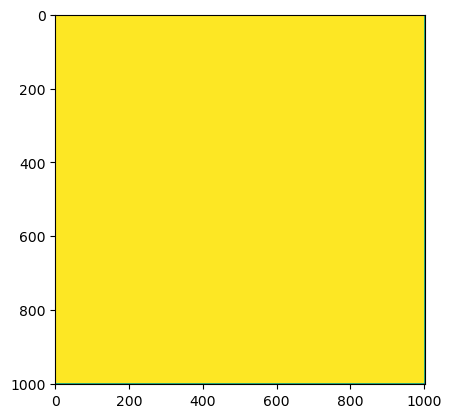

In [11]:
from matplotlib import pyplot as plt
print("testing specify map generation")

plt.ion()
state_map = np.pad(-np.random.randint(1,size=(1000,1000)), pad_width=1, constant_values=-1)
generator = manual_generator(state_map)
# generator = manual_generator(state_map)
world = generator()

plt.imshow(world[0])
plt.pause(0.1)
plt.ioff()
plt.show()

testing randomized map generation
density:530, components:2


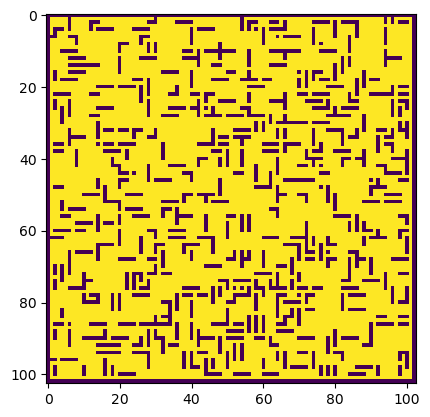

In [8]:
from matplotlib import pyplot as plt
print("testing randomized map generation")
plt.ion()
generator = maze_generator(env_size=(100,100),obstacle_density=[0.1,0.1], wall_components=(2,2))
# generator = manual_generator(state_map)
world = generator()

plt.imshow(world[0])
plt.pause(0.1)
plt.ioff()
plt.show()

KeyboardInterrupt: 

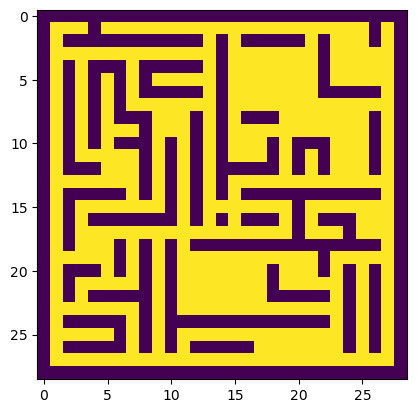

In [11]:
if __name__ == "__main__":
    from matplotlib import pyplot as plt
    from IPython.display import display, clear_output
    import time
    
    print("testing randomized map generation")
    plt.ion()
    fig, ax = plt.subplots()
    for _ in range(1000):
        generator = maze_generator()
        world = generator()
        ax.imshow(world[0])
        display(fig)
        clear_output(wait=True)
        time.sleep(0.1)
        # plt.imshow(world[0])  # obstacle map
        # plt.pause(0.1)
    plt.ioff()
    plt.show()